In [6]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import combinations
from tqdm import tqdm

# Basics

0.8401304


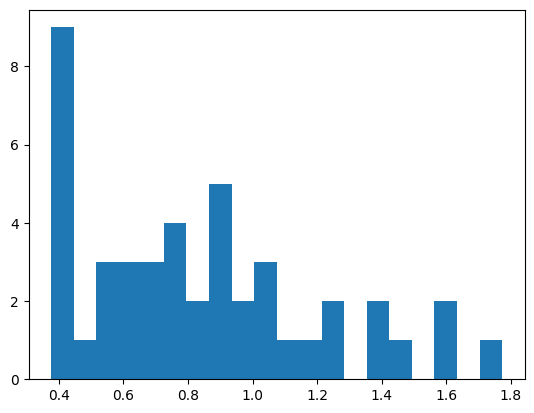

In [ ]:
traj = md.load(
	"/home/shpark/prj-mlcv/lib/DESRES/data/CLN025_desres.pdb"
)
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
ca_distance, _ = md.compute_contacts(
	traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(ca_distance.mean())
plt.hist(ca_distance.flatten(), bins=20)
plt.show()

In [11]:
base_dir = "../DESRES-Trajectory_CLN025-0-protein"
traj_list = []
for i in tqdm(
    range(53),
    desc="Loading trajectories"
):  # 0 to 52 inclusive
    file_idx = f"{i:03d}"
    traj = md.load_dcd(
        f"{base_dir}/CLN025-0-protein/CLN025-0-protein-{file_idx}.dcd",
        top="../data/CLN025_desres.pdb"
    )
    traj_list.append(traj)
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 53/53 [00:01<00:00, 39.73it/s]


(530000, 45)


In [ ]:
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
all_traj_ca_pair_distances, _ = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(all_traj_ca_pair_distances.shape)

# save_dir = "/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-CAdistance.pt"
# torch.save(torch.from_numpy(all_traj_ca_pair_distances), save_dir)

# Small size dataset generation

In [12]:
simulation_idx = 0
cln025_cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-{simulation_idx}-protein/CLN025-{simulation_idx}-CAdistance.pt"
cln025_pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-{simulation_idx}-protein/CLN025-{simulation_idx}-coordinates.pt"
cad_data = torch.load(cln025_cad_path)
pos_data = torch.load(cln025_pos_path)

print(cad_data.shape)
print(pos_data.shape)

torch.Size([530000, 45])
torch.Size([530000, 166, 3])


In [20]:
time_lag_list = [1, 5, 10, 100]
data_num = pos_data.shape[0]
dataset_size = 5000
num_data_str = str(dataset_size // 1000) + "k"
selected_idx = torch.from_numpy(np.random.choice(data_num - max(time_lag_list) - 1, size = dataset_size, replace=False))

current_pos = pos_data[selected_idx]
current_cad = cad_data[selected_idx]
torch.save(current_pos, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{num_data_str}/current-pos.pt")
torch.save(current_cad, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{num_data_str}/current-cad.pt")

for time_lag in time_lag_list:
	print(time_lag)
	next_pos = pos_data[selected_idx + time_lag]
	next_cad = cad_data[selected_idx + time_lag]
	torch.save(next_pos, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{num_data_str}/lag{time_lag}-pos.pt")
	torch.save(next_cad, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{num_data_str}/lag{time_lag}-cad.pt")

1
5
10
100


# Stats

## CAD, pos stats

In [91]:
dataset_size_str = "5k"
selected_lag = 5

current_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{dataset_size_str}/current-pos.pt")
current_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{dataset_size_str}/current-cad.pt")
time_lagged_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{dataset_size_str}/lag{selected_lag}-pos.pt")
time_lagged_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-{dataset_size_str}/lag{selected_lag}-cad.pt")

print(current_pos.shape)
print(current_cad.shape)
print(time_lagged_pos.shape)
print(time_lagged_cad.shape)

torch.Size([5000, 166, 3])
torch.Size([5000, 45])
torch.Size([5000, 166, 3])
torch.Size([5000, 45])


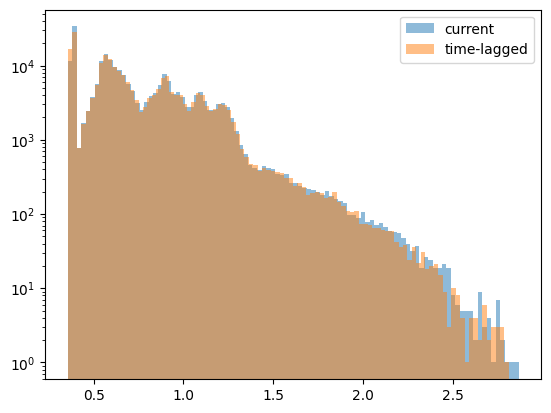

Current CAD mean: 0.7381
Time-lagged CAD mean: 0.7373
Current CAD max: 2.8676
Time-lagged CAD max: 2.8129


In [92]:
plt.hist(current_cad.flatten(), bins=100, alpha=0.5, log=True, label="current")
plt.hist(time_lagged_cad.flatten(), bins=100, alpha=0.5, log=True, label="time-lagged")
plt.legend()
plt.show()

print(f"Current CAD mean: {current_cad.mean():.4f}")
print(f"Time-lagged CAD mean: {time_lagged_cad.mean():.4f}")
print(f"Current CAD max: {current_cad.max():.4f}")
print(f"Time-lagged CAD max: {time_lagged_cad.max():.4f}")

## Foldedness and transitions

In [93]:
def foldedness_by_hbond(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int) 
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff)).astype(int)




	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + label_ASP3N_TYR8O + label_THR6OG1_ASP3O \
		+ label_THR6N_ASP3OD1 + label_THR6N_ASP3OD2 + label_GLY7N_ASP3O + label_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	# print(label_TYR10OT_TYR1N.sum())
	# print(labels_TYR10N_TYR1O.sum())
	# print(labels_ASP3OD_THR6OG1.sum())
	# print(labels_ASP3N_TYR8O.sum())

	return labels, bond_sum

Current label mean: 0.7816
Current bond num mean: 3.7712
Current bond num max: 6.0000
Timelagged label mean: 0.7826
Timelagged bond num mean: 3.7738
Timelagged bond num max: 7.0000


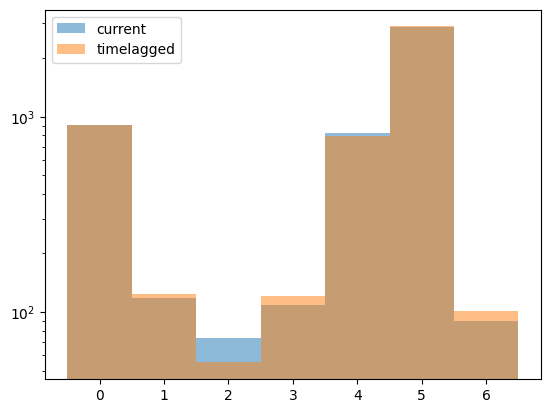

In [94]:
traj = md.load("/home/shpark/prj-mlcv/lib/DESRES/data/CLN025_desres.pdb")
traj.xyz = current_pos.numpy()
current_label, current_bond_num = foldedness_by_hbond(traj)
traj.xyz = time_lagged_pos.numpy()
timelagged_label, timelagged_bond_num = foldedness_by_hbond(traj)
bins = np.arange(-0.5, 7.5, 1)

print(f"Current label mean: {current_label.mean():.4f}")
print(f"Current bond num mean: {current_bond_num.mean():.4f}")
print(f"Current bond num max: {current_bond_num.max():.4f}")
print(f"Timelagged label mean: {timelagged_label.mean():.4f}")
print(f"Timelagged bond num mean: {timelagged_bond_num.mean():.4f}")
print(f"Timelagged bond num max: {timelagged_bond_num.max():.4f}")

plt.hist(current_bond_num, bins=bins, alpha=0.5, log=True, label="current")
plt.hist(timelagged_bond_num, bins=bins, alpha=0.5, log=True, label="timelagged")
plt.xticks(range(0, 7))
plt.legend()
plt.show()

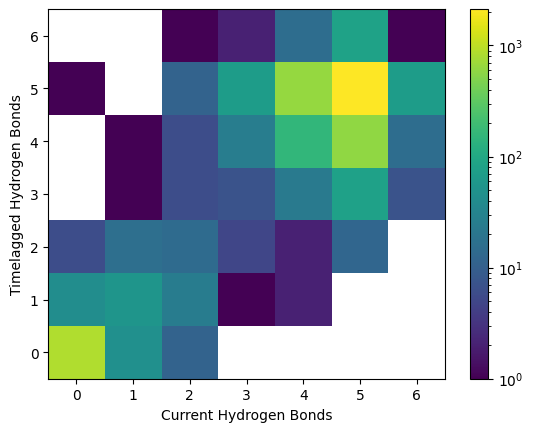

In [95]:
from matplotlib.colors import LogNorm

# plt.scatter(current_bond_num, timelagged_bond_num)
hist, xedges, yedges, _ = plt.hist2d(
    current_bond_num,
    timelagged_bond_num,
    bins=[np.arange(-0.5,7.5,1), np.arange(-0.5,7.5,1)],
    norm=LogNorm()
)
plt.xlabel("Current Hydrogen Bonds")
plt.ylabel("Timelagged Hydrogen Bonds")
plt.colorbar()
plt.show()

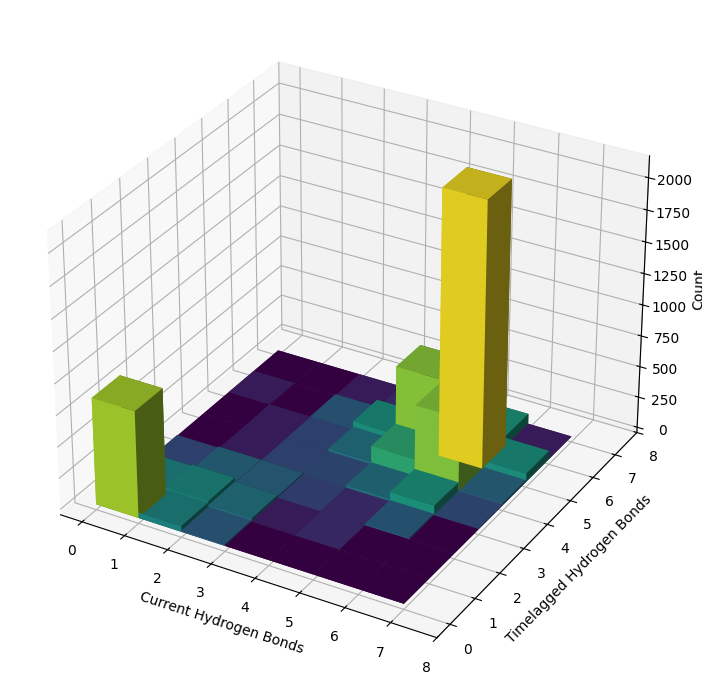

In [96]:
# Construct positions for the bars
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5, yedges[:-1] + 0.5, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 1
dz = hist.ravel()

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis(np.log1p(dz) / np.log1p(dz.max()))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')
ax.set_xlabel('Current Hydrogen Bonds')
ax.set_ylabel('Timelagged Hydrogen Bonds')
ax.set_zlabel('Count')
ax.set_xticks(range(9))
ax.set_yticks(range(9))
plt.tight_layout()
plt.show()

Folded2unfolded: 22
Unfolded2folded: 27
Total: 49 / 5000 (0.98%)


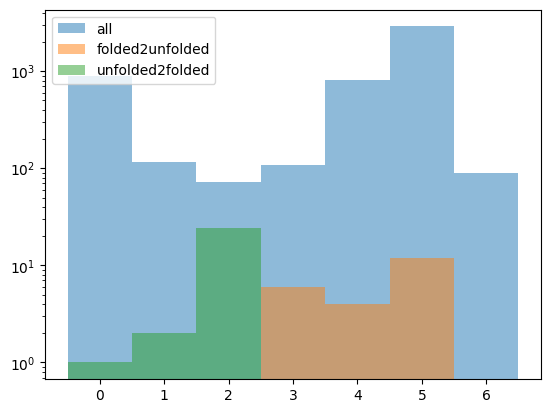

In [97]:
folded2unfolded = (current_label == 1) & (timelagged_label == 0)
unfolded2folded = (current_label == 0) & (timelagged_label == 1)

print(f"Folded2unfolded: {folded2unfolded.sum()}")
print(f"Unfolded2folded: {unfolded2folded.sum()}")
print(f"Total: {folded2unfolded.sum() + unfolded2folded.sum()} / {current_bond_num.shape[0]} ({(folded2unfolded.sum() + unfolded2folded.sum()) / current_bond_num.shape[0] * 100:.2f}%)")

plt.hist(current_bond_num, bins=bins, alpha=0.5, log=True, label="all")
plt.hist(current_bond_num[folded2unfolded], bins=bins, alpha=0.5, log=True, label="folded2unfolded")
plt.hist(current_bond_num[unfolded2folded], bins=bins, alpha=0.5, log=True, label="unfolded2folded")
plt.xticks(range(0, 7))
plt.legend()
plt.show()